<a href="https://colab.research.google.com/github/theokunj/practice/blob/main/ME_HW1_Img_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Soybean Segmented subplots



In [40]:
# import libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from scipy import ndimage
import zipfile
from PIL import Image

In [42]:
zip_file_path = '/content/Agricultural_Image_Analytics.zip'
extraction_dir = '/content/Agricultural_Image_Analytics_extracted'

# Create the destination directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Successfully extracted '{zip_file_path}' to '{extraction_dir}'")

Successfully extracted '/content/Agricultural_Image_Analytics.zip' to '/content/Agricultural_Image_Analytics_extracted'


In [43]:
extracted_contents = os.listdir(extraction_dir)
print(f"Contents of '{extraction_dir}':\n{extracted_contents}")

Contents of '/content/Agricultural_Image_Analytics_extracted':
['Agricultural_Image_Analytics', '__MACOSX']


In [44]:
data_dir = os.path.join(extraction_dir, 'Agricultural_Image_Analytics')
print(f"Contents of '{data_dir}':\n{os.listdir(data_dir)}")

Contents of '/content/Agricultural_Image_Analytics_extracted/Agricultural_Image_Analytics':
['5.JPG', '3.JPG', 'leaves', '1.JPG', '2.JPG', '.DS_Store', '4.JPG']


## Load and Inspect Image



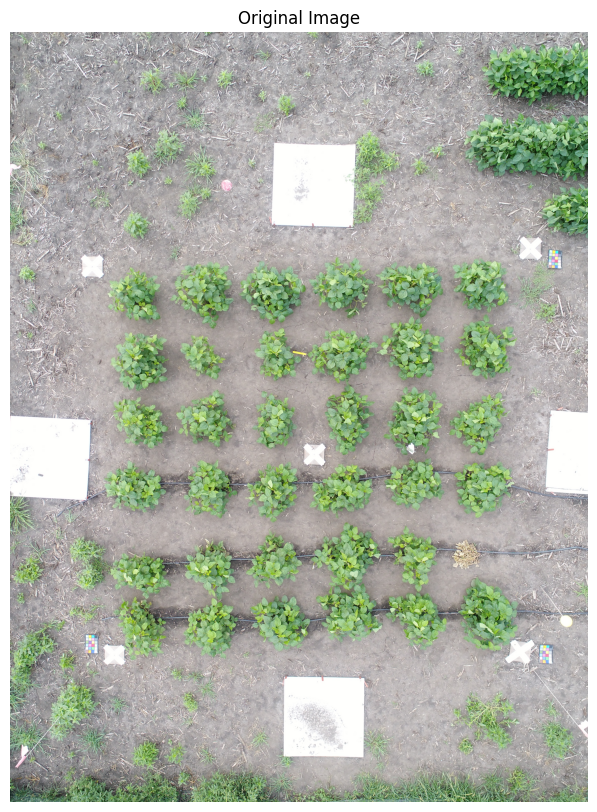

Image shape: (4864, 3648, 3)


In [72]:
image_path = os.path.join(data_dir, '4.JPG')
img = cv.imread(image_path)

# Convert BGR to RGB for display
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

print(f"Image shape: {img.shape}")

## Step 1: ROI Extraction
Detect bright/white markers to crop the image to the relevant area.


Markers found (Top 9): 9
Selected markers for ROI (Smallest 5 of top 9): 5
Original shape: (4864, 3648, 3)
Detected Crop Coordinates: x=435, y=1291, w=2926, h=2786
ROI shape: (2786, 2926, 3)


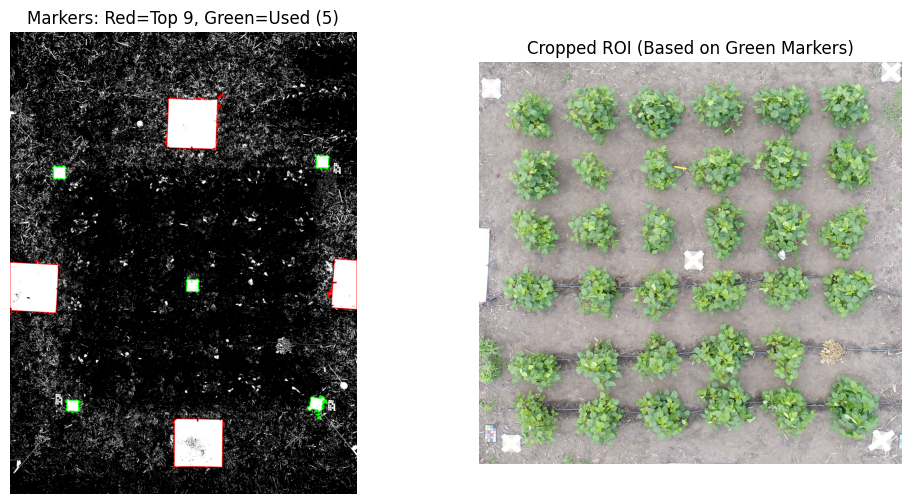

In [73]:
# Convert to grayscale
gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

# Apply binary threshold to isolate bright markers (white areas)
# Use a high threshold (e.g., 200) to detect white objects
_, mask_roi = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

# Find contours
contours, _ = cv.findContours(mask_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter for large contours to ignore noise (area > 1000)
large_contours = [cnt for cnt in contours if cv.contourArea(cnt) > 1000]

# Sort by area (descending) and keep only the top 9
large_contours = sorted(large_contours, key=cv.contourArea, reverse=True)[:9]

# Save as an object array
markers = np.array(large_contours, dtype=object)
print(f"Markers found (Top 9): {len(markers)}")

#Idnetify small x and exclude the large squares
# Since large_contours is sorted descending (largest first), the smallest 5 are the last 5
selected_markers = markers[-5:] if len(markers) >= 5 else markers
print(f"Selected markers for ROI (Smallest 5 of top 9): {len(selected_markers)}")

if len(selected_markers) > 0:
    # Concatenate points from selected markers to find the encompassing bounding box
    all_points = np.concatenate(selected_markers)
    x, y, w, h = cv.boundingRect(all_points)

    # Crop the image
    roi = img_rgb[y:y+h, x:x+w]

    print(f"Original shape: {img_rgb.shape}")
    print(f"Detected Crop Coordinates: x={x}, y={y}, w={w}, h={h}")
    print(f"ROI shape: {roi.shape}")

    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Draw selected contours on the mask for visualization
    mask_vis = cv.cvtColor(mask_roi, cv.COLOR_GRAY2RGB)
    # Draw all top 9 in red first to show context
    cv.drawContours(mask_vis, large_contours, -1, (255, 0, 0), 5)
    # Draw the selected 5 in Green to show what determines the crop
    cv.drawContours(mask_vis, list(selected_markers), -1, (0, 255, 0), 10)

    axes[0].imshow(mask_vis)
    axes[0].set_title(f'Markers: Red=Top 9, Green=Used ({len(selected_markers)})')
    axes[0].axis('off')

    axes[1].imshow(roi)
    axes[1].set_title('Cropped ROI (Based on Green Markers)')
    axes[1].axis('off')

    plt.show()
else:
    print("No markers found.")
    roi = img_rgb.copy()

## Step 2: Green Segmentation
Convert the ROI to HSV and segment green plant areas using color thresholding.


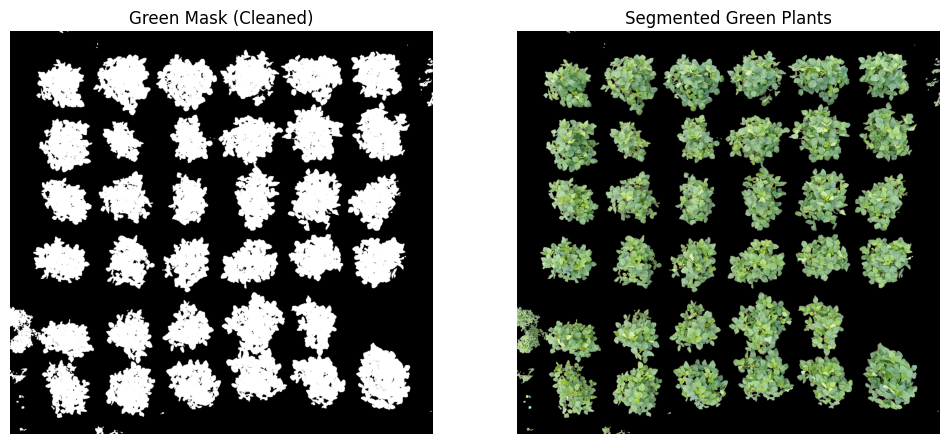

In [74]:
# Convert ROI to HSV
hsv_roi = cv.cvtColor(roi, cv.COLOR_RGB2HSV)

# Define HSV range for green
lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])

# Create binary mask
mask_green = cv.inRange(hsv_roi, lower_green, upper_green)

# Apply morphological opening to remove noise
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv.morphologyEx(mask_green, cv.MORPH_OPEN, kernel)

# Segment the image
segmented_img = cv.bitwise_and(roi, roi, mask=mask_cleaned)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mask_cleaned, cmap='gray')
axes[0].set_title('Green Mask (Cleaned)')
axes[0].axis('off')

axes[1].imshow(segmented_img)
axes[1].set_title('Segmented Green Plants')
axes[1].axis('off')

plt.show()

#
Filter out small artifacts (e.g., area < 500 pixels) to keep only significant plant clusters. Implement a sorting mechanism

## Step 3: Object Detection & Labeling

Detect individual plants, filter noise, sort them in a grid


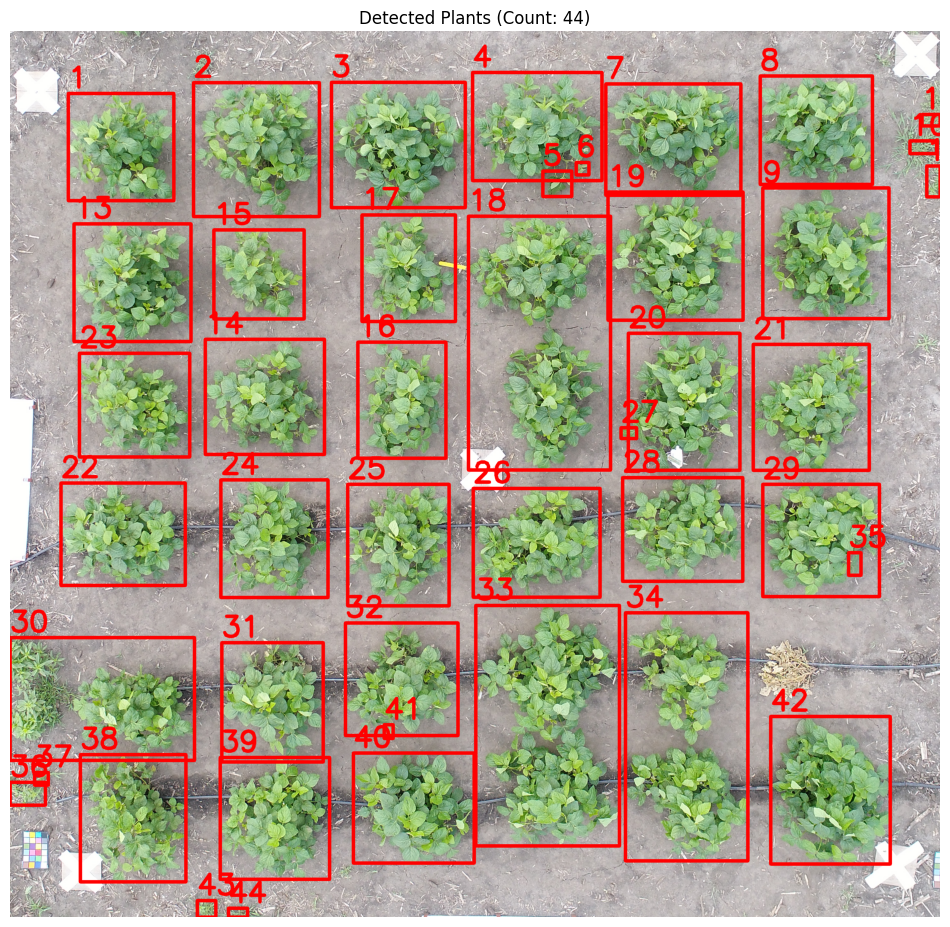

In [75]:
# Find contours on the cleaned mask
contours, _ = cv.findContours(mask_cleaned, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter contours to keep only those with area > 500
min_area = 500
valid_contours = [c for c in contours if cv.contourArea(c) > min_area]

# Sort contours: Top-to-bottom (rows), then Left-to-right (columns)
# We use a threshold (e.g., 500 pixels) to group contours into rows based on Y coordinate
valid_contours.sort(key=lambda c: (cv.boundingRect(c)[1] // 500, cv.boundingRect(c)[0]))

# Create a copy of the ROI to draw on
labeled_img = roi.copy()

#limit number of valid contours
#valid_contours = valid_contours[:36]

# Loop through sorted contours and label them
for i, cnt in enumerate(valid_contours, start=1):
    # Get bounding box
    x, y, w, h = cv.boundingRect(cnt)

    # Draw rectangle (Red color in RGB)
    cv.rectangle(labeled_img, (x, y), (x + w, y + h), (255, 0, 0), 10)

    # Put ID label
    label = str(i)
    # Position text slightly above the box; ensure it doesn't go off-screen
    text_y = y - 20 if y - 20 > 50 else y + h + 50
    cv.putText(labeled_img, label, (x, text_y), cv.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 10)

# Display the final labeled image
plt.figure(figsize=(12, 12))
plt.imshow(labeled_img)
plt.title(f'Detected Plants (Count: {len(valid_contours)})')
plt.axis('off')
plt.show()

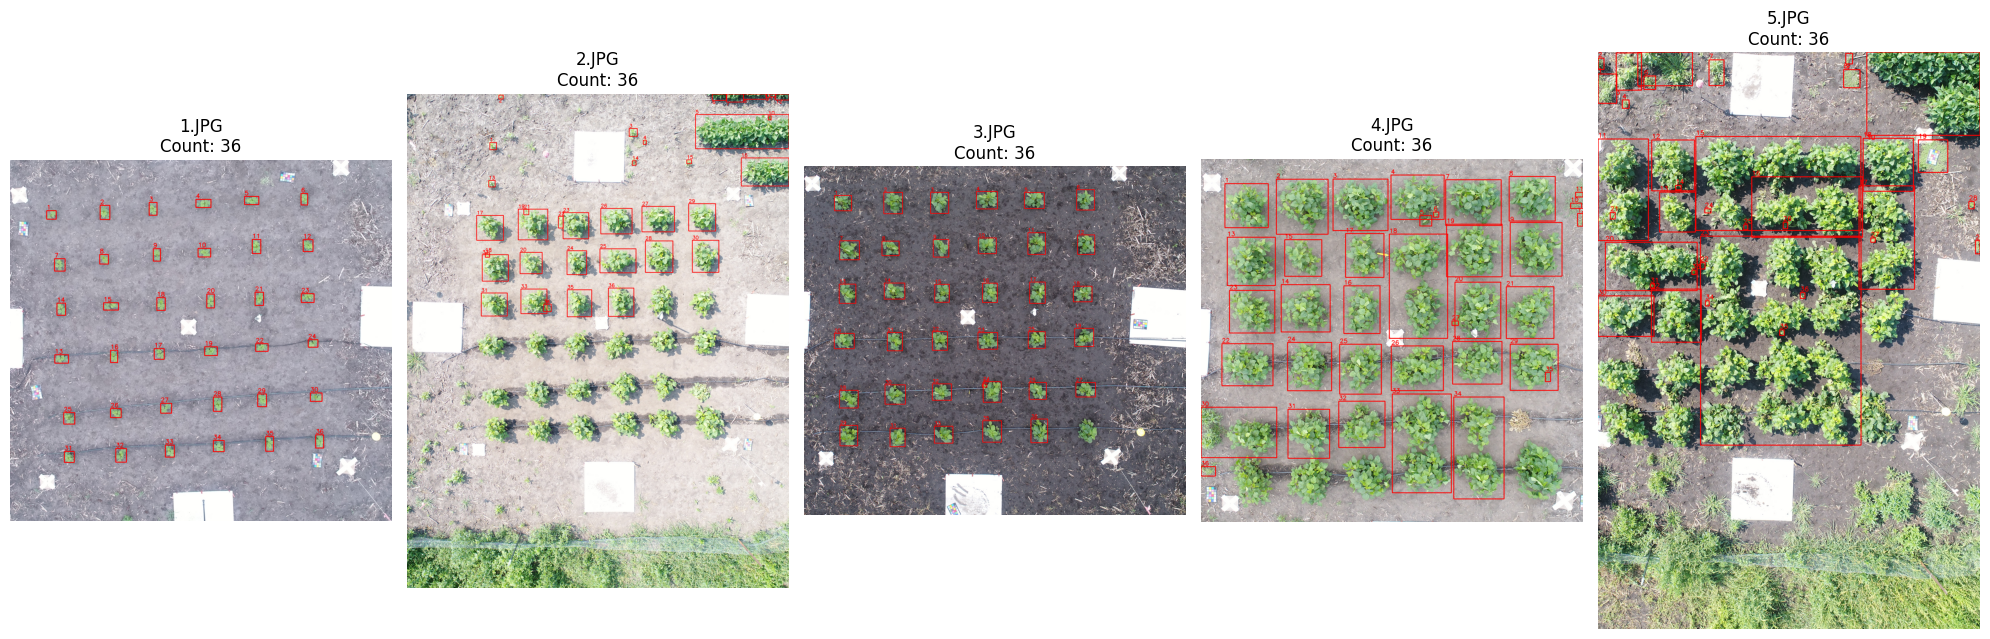

In [49]:
image_files = ['1.JPG', '2.JPG', '3.JPG', '4.JPG', '5.JPG']

# Define processing parameters
kernel = np.ones((5, 5), np.uint8)
lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])

plt.figure(figsize=(20, 8))

for idx, filename in enumerate(image_files):
    # Load image
    img_path = os.path.join(data_dir, filename)
    img = cv.imread(img_path)
    if img is None:
        print(f"Warning: Could not load {filename}")
        continue
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # --- ROI Extraction ---
    gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
    _, mask_roi = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(mask_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter area > 1000
    large_contours = [cnt for cnt in contours if cv.contourArea(cnt) > 1000]
    # Sort descending and keep top 9
    large_contours = sorted(large_contours, key=cv.contourArea, reverse=True)[:9]
    # Select smallest 5 of top 9 (the last 5 in the descending list)
    selected_markers = large_contours[-5:] if len(large_contours) >= 5 else large_contours

    if len(selected_markers) > 0:
        all_points = np.concatenate(selected_markers)
        x, y, w, h = cv.boundingRect(all_points)
        roi = img_rgb[y:y+h, x:x+w]
    else:
        roi = img_rgb.copy()

    # --- Green Segmentation ---
    hsv_roi = cv.cvtColor(roi, cv.COLOR_RGB2HSV)
    mask_green = cv.inRange(hsv_roi, lower_green, upper_green)
    mask_cleaned = cv.morphologyEx(mask_green, cv.MORPH_OPEN, kernel)

    # --- Labeling ---
    plant_contours, _ = cv.findContours(mask_cleaned, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Filter area > 500
    valid_plants = [c for c in plant_contours if cv.contourArea(c) > 500]

    # Sort: Top-to-bottom (rows), then Left-to-right
    valid_plants.sort(key=lambda c: (cv.boundingRect(c)[1] // 500, cv.boundingRect(c)[0]))

    # Limit to 36 plants
    valid_plants = valid_plants[:36]

    # Draw on ROI
    labeled_img = roi.copy()
    for i, cnt in enumerate(valid_plants, start=1):
        x_p, y_p, w_p, h_p = cv.boundingRect(cnt)
        cv.rectangle(labeled_img, (x_p, y_p), (x_p + w_p, y_p + h_p), (255, 0, 0), 5)
        # Adjust text position
        text_y = y_p - 10 if y_p - 10 > 20 else y_p + h_p + 30
        cv.putText(labeled_img, str(i), (x_p, text_y), cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4)

    # Display
    plt.subplot(1, 5, idx + 1)
    plt.imshow(labeled_img)
    plt.title(f"{filename}\nCount: {len(valid_plants)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
print("Batch processing of images 1.JPG through 5.JPG is complete.")

Batch processing of images 1.JPG through 5.JPG is complete.
